In [1]:
# For data analysis
import os
import numpy as np
import pandas as pd

# For plotting
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt 
from pylab import rcParams
%matplotlib inline

In [2]:
rcParams["figure.figsize"] = [16, 9]
rcParams["font.family"] = "Helvetica"
# rcParams['font.sans-serif']=['SimHei']
sns.set_context("paper", font_scale=2.5)
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
pd.set_option("show_dimensions", True)

In [12]:
# set path
data_path = "D:\\EGI_DATA\\EGI_FMT"
beh_path = "beh"
new_data_path = "../new_data"
# set task name
foodtask = "foodchoice"
wordtask = "wordchoice"
imagetask = "imagechoice"
witask = "wordimagematch"

In [4]:
exclude_sub = ["sub-004", "sub-013", "sub-020"]

In [5]:
max_time = 3000
# read animacy table
animacy_path = "../assets/animacy.xlsx"
association_path = "../assets/association.csv"
animacy = pd.read_excel(animacy_path, sheet_name=0)
association = pd.read_csv(association_path)

In [6]:
# get animacy dict of words
animacy_dict = {}
for index, row in animacy.iterrows():
    animacy_dict[row["animate"]] = "animate"
    animacy_dict[row["non-animate"]] = "inanimate"

In [7]:
# word/image match dict in wordimageChoice task
association["relation"] = association.isMatch.map({True: "match", False: "nomatch"})
association = association[["item_word", "item_image", "relation"]]
association.drop_duplicates(inplace=True)
match_dict = {}
for index, row in association.iterrows():
    match_dict[row["item_word"]] = row["relation"]
    match_dict[row["item_image"]] = row["relation"]

In [8]:
img2word_dict = dict(zip(association["item_image"], association["item_word"]))

## read data

In [9]:
stim_rec = {
    foodtask: ["image_right.started", "image_right_2.started"],
    wordtask: ["word_item.started", "word_item_2.started"],
    imagetask: ["image_item.started", "image_item_2.started"],
    witask: ["word_item.started", "word_item_2.started"]
}

In [10]:
def summaryData(task):
    def get_path(sub, task):
        return os.path.join(data_path, sub, beh_path, "{}_task-{}_beh.csv".format(sub, task))
    time_list = []
    # get head
    columns = pd.read_csv(get_path("sub-001", task)).columns
    summary_df = pd.DataFrame(columns=columns)
    for sub in tqdm(os.listdir(data_path)):
        if sub in exclude_sub:
            continue
        df = pd.read_csv(get_path(sub, task))
        time_list.append(df["text.started"][321])
        df = df[1:321]
        df["sub"] = sub
        df["rt"] = df[stim_rec[task]].apply(lambda x: np.round((x[stim_rec[task][1]] - x[stim_rec[task][0]]) * 1000), axis=1)
        # remove outlier rt data
        lower_bound = df.rt.mean() - 3 * df.rt.std()
        upper_bound = df.rt.mean() + 3 * df.rt.std()
        df = df[(lower_bound < df.rt) & (df.rt < upper_bound)]
        # append to new df
        summary_df = pd.concat([summary_df, df], axis=0, ignore_index=True)
    print("{} mean time: {}".format(task, np.mean(time_list) / 60))
    return summary_df

In [13]:
food_df = summaryData(foodtask)
word_df = summaryData(wordtask)
image_df = summaryData(imagetask)
wi_df = summaryData(witask)

 10%|▉         | 3/31 [00:00<00:00, 28.30it/s]

foodchoice mean time: 26.684969689011233


 10%|▉         | 3/31 [00:00<00:01, 27.27it/s]

wordchoice mean time: 24.95112113017979


 10%|▉         | 3/31 [00:00<00:01, 26.33it/s]

imagechoice mean time: 25.49051586013104


100%|██████████| 31/31 [00:01<00:00, 26.21it/s]

wordimagematch mean time: 26.660472569196155


## foodChoice

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


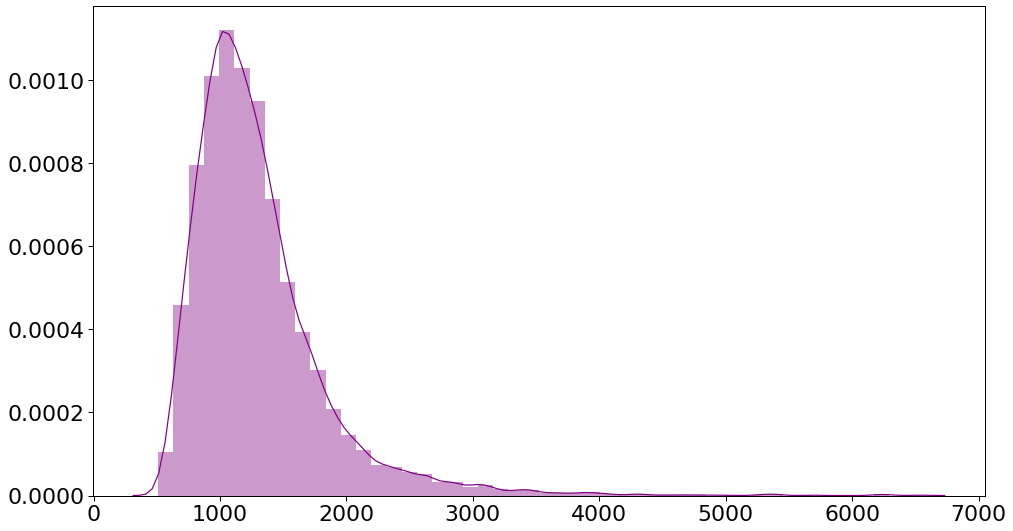

In [12]:
fig = sns.distplot(food_df["rt"], color="purple")
# ticks = fig.get_yticks().tolist() + [0.0016]
# ylabels = ['{:.2f}'.format(x * 100) for x in fig.get_yticks()]
# fig.set_yticklabels(ylabels)
# fig.set_yticks(ticks)
plt.xlabel("")
plt.ylabel("")
plt.legend([],[], frameon=False)
# plt.title("Food Choice RT", y=1.01)
# plt.savefig("../figures/foodchoice/rt.svg", bbox_inches="tight")

## wordChoice

In [14]:
# rename option
for option in ["option_left", "option_right"]:
    word_df[option] = word_df[option].map({"有生命":"animate", "无生命":"inanimate"})
# rename mouse.clicked_name columns
word_df["mouse.clicked_name"] = word_df["mouse.clicked_name"].map({"rect_left":"left", "rect_right":"right"})
word_df.rename(columns={"mouse.clicked_name":"side", "words.thisN":"trialN"}, inplace=True)

In [15]:
# get animacy of word
word_df["animacy"] = word_df["item"].apply(lambda x: animacy_dict[x])
# match relation in wordimageChoice
word_df["relation"] = word_df["item"].apply(lambda x: match_dict[x])
# get mouse response
word_df["response"] = word_df.apply(lambda x: x["option_left"] if x["side"] == "left" else x["option_right"], axis=1)
# calculate correct
word_df["correct"] = word_df.apply(lambda x: x["animacy"] == x["response"], axis=1)
# store stim type
word_df["stimuli"] = "word"

### wordChoice RT

In [16]:
word_df.groupby("sub").mean()["correct"].reset_index()

,sub,correct
0,sub-001,0.942492
1,sub-002,0.990446
2,sub-003,0.980892
3,sub-005,0.980892
4,sub-006,0.907348
5,sub-007,0.918239
6,sub-008,0.996805
7,sub-009,0.993631
8,sub-010,0.980831
9,sub-011,0.974603


In [17]:
word_df_corr = word_df[word_df["correct"] == True]

<ipython-input-18-b7329a581ccc>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fig = sns.distplot(word_df_corr[word_df["animacy"] == "animate"]["rt"], color="green", label="animate")
C:\Users\Kun Chen\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-18-b7329a581ccc>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(word_df_corr[word_df["animacy"] == "inanimate"]["rt"], color="purple", label="inanimate")
C:\Users\Kun Chen\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `

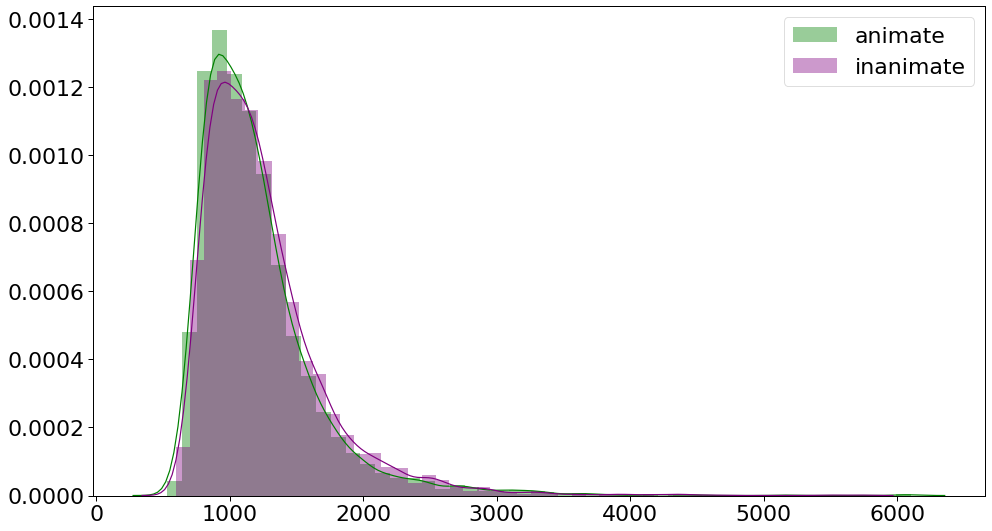

In [18]:
# animate/non-animate
fig = sns.distplot(word_df_corr[word_df["animacy"] == "animate"]["rt"], color="green", label="animate")
sns.distplot(word_df_corr[word_df["animacy"] == "inanimate"]["rt"], color="purple", label="inanimate")
plt.legend()
plt.xlabel("")
plt.ylabel("")
# plt.title("Word Choice RT", y=1.01)
plt.savefig("../figures/wordchoice/rt-animacy.svg", bbox_inches="tight")

Text(0.5, 1.0, 'wordChoice RT Distribution')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


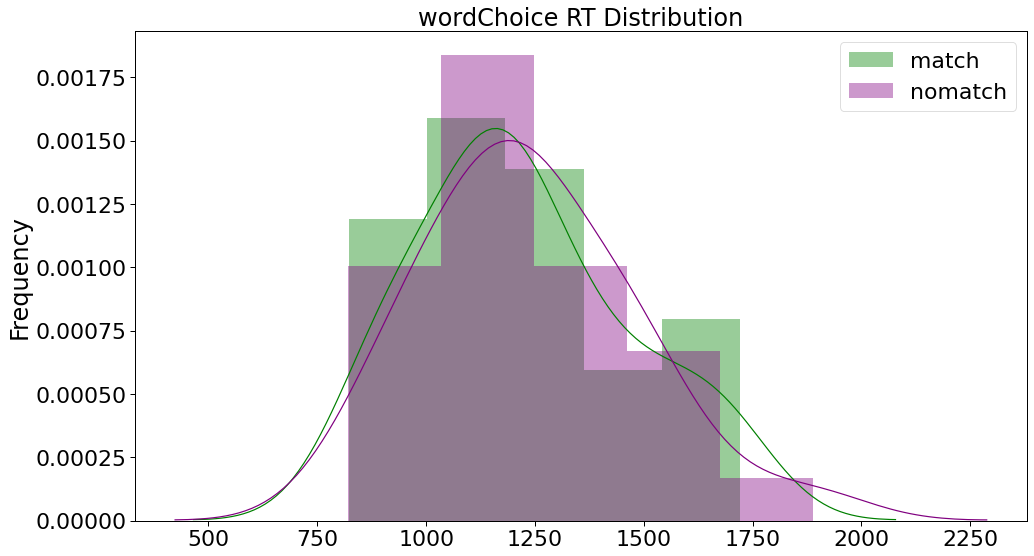

In [18]:
# match/nomatch
sns.distplot(word_df_corr[word_df_corr["relation"] == "match"].groupby("sub")["rt"].mean(), color="green", label="match")
sns.distplot(word_df_corr[word_df_corr["relation"] == "nomatch"].groupby("sub")["rt"].mean(), color="purple", label="nomatch")
plt.legend()
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("wordChoice RT Distribution")
# plt.savefig("./figures/wordchoice/rt-match.svg", bbox_inches="tight")

In [19]:
stats.ttest_rel(word_df_corr[word_df_corr["relation"] == "match"].groupby("sub")["rt"].mean(), word_df_corr[word_df_corr["relation"] == "nomatch"].groupby("sub")["rt"].mean())

Ttest_relResult(statistic=-1.241263462245537, pvalue=0.22518475157824852)

In [20]:
stats.ttest_rel(word_df_corr[word_df_corr["animacy"] == "animate"].groupby("sub")["rt"].mean(), word_df_corr[word_df_corr["animacy"] == "inanimate"].groupby("sub")["rt"].mean())

Ttest_relResult(statistic=-5.384927814384622, pvalue=1.0845519962603032e-05)

### wordChoice accuracy

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


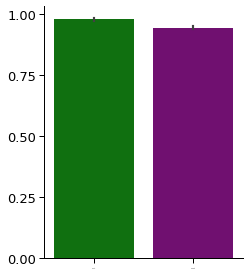

In [21]:
# accuracy
fig = sns.catplot(x="animacy", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=word_df, aspect=0.9)
# fig.set(ylim=(0.9, 1))
# plt.xlabel("condition")
plt.xlabel("")
plt.ylabel("")
plt.xticks(size=0)
plt.yticks(size=13)
# plt.title("Word Choice Accuracy", y=1.01)
plt.savefig("../figures/wordchoice/acc-animacy.svg", bbox_inches="tight")

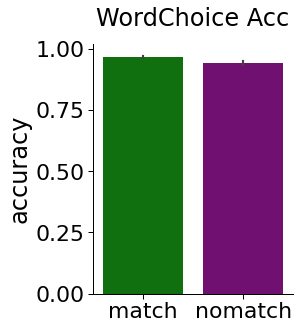

In [22]:
# accuracy
sns.catplot(x="relation", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=word_df, aspect=0.9)
plt.xlabel("")
plt.ylabel("accuracy")
plt.title("WordChoice Acc", y=1.05)
plt.savefig("../figures/wordchoice/acc-match.svg", bbox_inches="tight")

In [23]:
word_acc_df = word_df.groupby(["sub", "relation"])["correct"].mean().reset_index()

<AxesSubplot:xlabel='relation', ylabel='correct'>

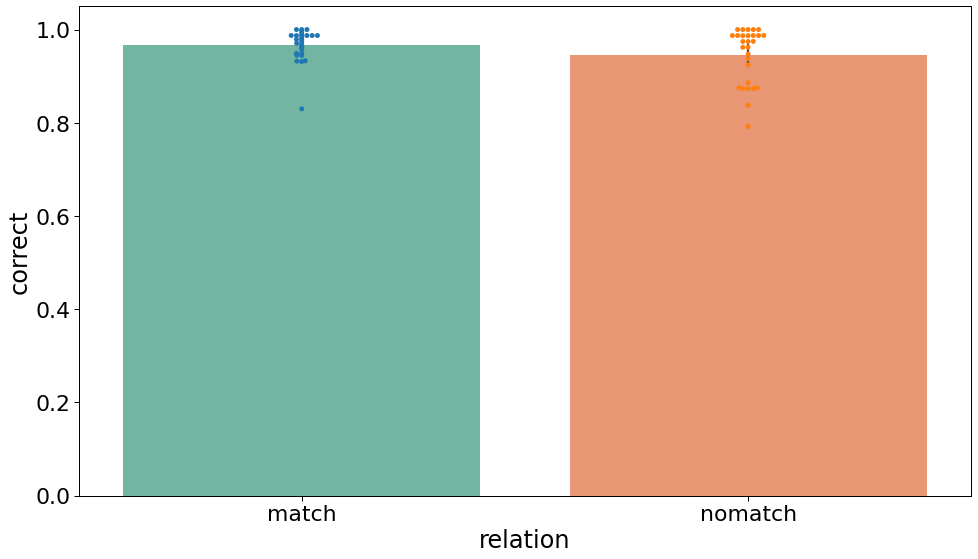

In [24]:
sns.swarmplot(x="relation", y="correct", palette="tab10", data=word_acc_df)
sns.barplot(x="relation", y="correct", palette="Set2", data=word_acc_df)
# bar_ax.set(ylim=(0.5, 1))
# ax.set_xticklabels(rotation=90)

In [21]:
stats.ttest_rel(word_df[word_df["animacy"] == "animate"].groupby("sub")["correct"].mean(), word_df[word_df["animacy"] == "inanimate"].groupby("sub")["correct"].mean())

Ttest_relResult(statistic=2.8989126330492248, pvalue=0.00735039604763377)

In [22]:
stats.ttest_rel(word_df[word_df["relation"] == "match"].groupby("sub")["correct"].mean(), word_df[word_df["relation"] == "nomatch"].groupby("sub")["correct"].mean())

Ttest_relResult(statistic=3.450354872366336, pvalue=0.0018554507003632648)

In [38]:
word_cor = word_df.groupby(["sub", "relation", "animacy"])["correct"].mean().reset_index()

In [45]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols("correct ~ C(relation) + C(animacy) + C(relation):C(animacy)", data=word_cor).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq     df          F    PR(>F)
C(relation)             0.013449    1.0   3.291805  0.072403
C(animacy)              0.059301    1.0  14.515086  0.000231
C(relation):C(animacy)  0.016189    1.0   3.962497  0.049051
Residual                0.441231  108.0        NaN       NaN

[4 rows x 4 columns]


In [40]:
word_rt = word_df.groupby(["sub", "relation", "animacy"])["rt"].mean().reset_index()

In [44]:
model = ols("rt ~ C(relation) + C(animacy) + C(relation):C(animacy)", data=word_rt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                              sum_sq     df         F    PR(>F)
C(relation)             3.520270e+03    1.0  0.057476  0.810984
C(animacy)              4.826375e+04    1.0  0.788015  0.376674
C(relation):C(animacy)  1.056291e+04    1.0  0.172463  0.678756
Residual                6.614703e+06  108.0       NaN       NaN

[4 rows x 4 columns]


## imageChoice

In [30]:
image_df.groupby("sub")["rt"].mean()

sub
sub-001    1228.411392
sub-002    1578.501597
sub-003    1083.907643
sub-005    1336.238854
sub-006    1610.685897
sub-007    1319.341693
sub-008    1480.339683
sub-009    1022.834921
sub-010    1109.657143
sub-011    1098.563694
sub-012     832.044586
sub-014    1182.625397
sub-015    1396.298077
sub-016    1493.504762
sub-017    1234.217252
sub-018    1396.242038
sub-019    1083.278481
sub-021    1077.009494
sub-022    1081.413249
sub-023     978.517685
sub-024    1386.560127
sub-025    1498.009494
sub-026     890.210031
sub-027    1232.067093
sub-028    1197.345048
sub-029     973.457143
sub-030    1294.154574
sub-031    1333.663462
Name: rt, Length: 28, dtype: float64

In [31]:
# rename option
for option in ["option_left", "option_right"]:
    image_df[option] = image_df[option].map({"有生命": "animate", "无生命": "inanimate"})
# rename mouse.clicked_name columns
image_df["mouse.clicked_name"] = image_df["mouse.clicked_name"].map({"rect_left": "left", "rect_right": "right"})
image_df.rename(columns={"mouse.clicked_name":"side", "images.thisN":"trialN"}, inplace=True)

In [32]:
# get animacy of image
image_df["animacy"] = image_df["item"].apply(lambda x: x.split("/")[0])
image_df["animacy"] = image_df["animacy"].map({"animate": "animate", "non-animate": "inanimate"})
# match relation in wordimageChoice
image_df["relation"] = image_df["item"].apply(lambda x: match_dict[x])
# get mouse response
image_df["response"] = image_df.apply(lambda x: x["option_left"] if x["side"] == "left" else x["option_right"], axis=1)
# calculate correct
image_df["correct"] = image_df.apply(lambda x: x["animacy"] == x["response"], axis=1)
# replace image path with corresponding word
image_df["item"] = image_df["item"].map(img2word_dict)
# store stim type
image_df["stimuli"] = "image"

### imageChoice RT

In [33]:
image_df_corr = image_df[image_df["correct"] == True]

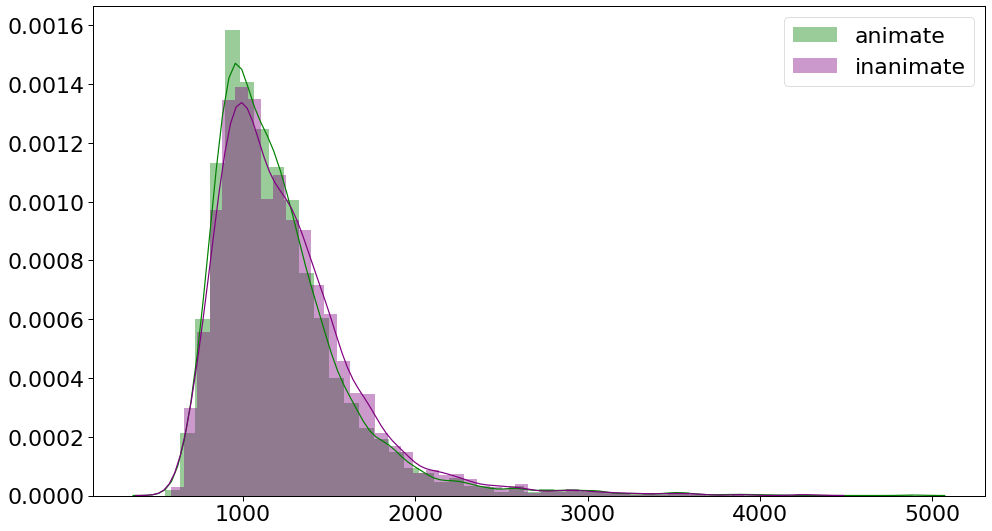

In [34]:
# animate/non-animate
fig = sns.distplot(image_df_corr[image_df_corr["animacy"] == "animate"]["rt"], color="green", label="animate")
sns.distplot(image_df_corr[image_df_corr["animacy"] == "inanimate"]["rt"], color="purple", label="inanimate")
# ylabels = ['{:.2f}'.format(x) for x in fig.get_yticks() * 100]
# fig.set_yticklabels(ylabels)
plt.legend()
plt.xlabel("")
plt.ylabel("")
# plt.title("Image Choice RT", y=1.01)
plt.savefig("../figures/imagechoice/rt-animacy.svg", bbox_inches="tight")

Text(0.5, 1.0, 'imageChoice RT Distribution')

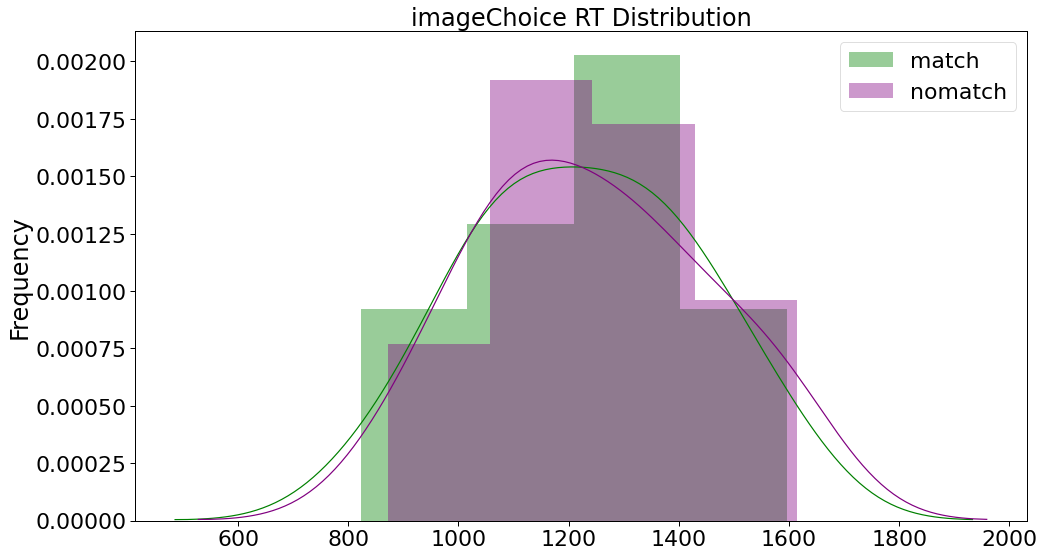

In [35]:
# match/nomatch
sns.distplot(image_df_corr[image_df_corr["relation"] == "match"].groupby("sub")["rt"].mean(), color="green", label="match")
sns.distplot(image_df_corr[image_df_corr["relation"] == "nomatch"].groupby("sub")["rt"].mean(), color="purple", label="nomatch")
plt.legend()
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("imageChoice RT Distribution")
# plt.savefig("./figures/wordchoice/rt-match.svg", bbox_inches="tight")

In [36]:
stats.ttest_rel(image_df_corr[image_df_corr["relation"] == "match"].groupby("sub")["rt"].mean(), image_df_corr[image_df_corr["relation"] == "nomatch"].groupby("sub")["rt"].mean())

Ttest_relResult(statistic=-1.9715042902011044, pvalue=0.05899371622563572)

### imageChoice acc

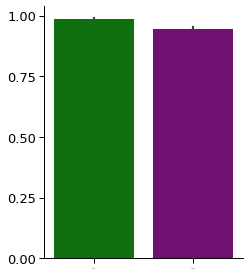

In [37]:
# accuracy
fig = sns.catplot(x="animacy", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=image_df, aspect=0.9)
# fig.set(ylim=(0.9, 1))
plt.xlabel("")
plt.ylabel("")
plt.xticks(size=0)
plt.yticks(size=13)
# plt.title("Image Choice Accuracy", y=1.01)
plt.savefig("../figures/imagechoice/acc-animacy.svg", bbox_inches="tight")

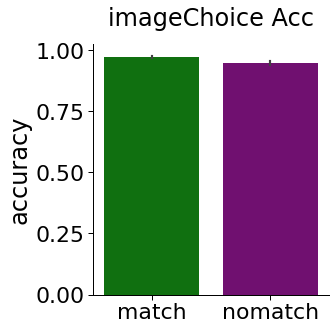

In [38]:
# accuracy
sns.catplot(x="relation", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=image_df)
plt.xlabel("")
plt.ylabel("accuracy")
plt.title("imageChoice Acc", y=1.05)
plt.savefig("../figures/imagechoice/acc-match.svg", bbox_inches="tight")

In [39]:
image_df.columns

Index(['item', 'option_left', 'option_right', 'images.thisRepN',
       'images.thisTrialN', 'trialN', 'images.thisIndex',
       'guide_image.started', 'guide_image.stopped', 'pause_tip.started',
       'pause_tip.stopped', 'ready_mouse.started', 'ready_mouse.stopped',
       'xTrajectory', 'yTrajectory', 'tTrajectory', 'mouse.x', 'mouse.y',
       'mouse.leftButton', 'mouse.midButton', 'mouse.rightButton', 'side',
       'mouse.started', 'mouse.stopped', 'image_item.started',
       'image_item.stopped', 'op_left.started', 'op_left.stopped',
       'image_item_2.started', 'image_item_2.stopped', 'op_left_2.started',
       'op_left_2.stopped', 'text.started', 'text.stopped', '姓名', '性别', '年龄',
       'date', 'expName', 'psychopyVersion', 'frameRate', 'Unnamed: 41', 'sub',
       'rt', 'animacy', 'relation', 'response', 'correct', 'stimuli'],
      dtype='object')

In [40]:
image_new = image_df.groupby(["sub", "relation", "animacy"])["correct"].mean().reset_index()

In [41]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols("correct ~ C(relation) + C(animacy) + C(relation):C(animacy)", data=image_new).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq     df          F    PR(>F)
C(relation)             0.018055    1.0   4.696924  0.032413
C(animacy)              0.064614    1.0  16.808771  0.000080
C(relation):C(animacy)  0.009758    1.0   2.538426  0.114028
Residual                0.415159  108.0        NaN       NaN

[4 rows x 4 columns]


## wordImageChoice

In [42]:
## recognize outliers in subjects and then exclude it manually
# mean_rt_df = pd.DataFrame(columns=["sub", "task", "rt"])
# for df, task in zip([food_df, wi_df, word_df, image_df], [foodtask, witask, wordtask, imagetask]):
#     rt_df = df.groupby("sub")["rt"].mean().to_frame().reset_index()
#     rt_df["task"] = task
#     mean_rt_df = pd.concat([mean_rt_df, rt_df], ignore_index=True)

In [43]:
# sns.boxplot(x="task", y="rt", data=mean_rt_df, palette="Set3")
# ax = sns.swarmplot(x="task", y="rt", data=mean_rt_df, color=".25")

In [44]:
# from matplotlib.cbook import boxplot_stats
# outliers = [y for stat in boxplot_stats(mean_rt_df["rt"]) for y in stat["fliers"]]

In [45]:
# outliers

In [46]:
# np.unique(mean_rt_df[mean_rt_df.rt > min(outliers)]["sub"])

In [47]:
# mean_rt_df[mean_rt_df["sub"] == "sub-020"]

In [48]:
# rename option
for option in ["option_left", "option_right"]:
    wi_df[option] = wi_df[option].map({"匹配":"match", "不匹配":"nomatch"})
# rename mouse.clicked_name columns
wi_df["mouse.clicked_name"] = wi_df["mouse.clicked_name"].map({"rect_left":"left", "rect_right":"right"})
wi_df.rename(columns={"mouse.clicked_name":"side",  "trials.thisN":"trialN"}, inplace=True)

In [49]:
# get animacy of word
wi_df["animacy"] = wi_df["item_word"].apply(lambda x: animacy_dict[x])
# match or not
wi_df["relation"] = wi_df["isMatch"].map({True:"match", False:"nomatch"})
# get mouse response
wi_df["response"] = wi_df.apply(lambda x: x["option_left"] if x["side"] == "left" else x["option_right"], axis=1)
# calculate correct
wi_df["correct"] = wi_df.apply(lambda x: x["relation"] == x["response"], axis=1)
# replace image path with word
wi_df["item_image"] = wi_df["item_image"].map(img2word_dict)

In [50]:
wi_df.columns

Index(['item_word', 'item_image', 'option_left', 'option_right', 'isMatch',
       'trials.thisRepN', 'trials.thisTrialN', 'trialN', 'trials.thisIndex',
       'guide_image.started', 'guide_image.stopped', 'pause_tip.started',
       'pause_tip.stopped', 'ready_mouse.started', 'ready_mouse.stopped',
       'xTrajectory', 'yTrajectory', 'tTrajectory', 'mouse.x', 'mouse.y',
       'mouse.leftButton', 'mouse.midButton', 'mouse.rightButton', 'side',
       'mouse.started', 'mouse.stopped', 'image_item.started',
       'image_item.stopped', 'word_item.started', 'word_item.stopped',
       'op_left.started', 'op_left.stopped', 'image_item_2.started',
       'image_item_2.stopped', 'word_item_2.started', 'word_item_2.stopped',
       'op_left_2.started', 'op_left_2.stopped', 'text.started',
       'text.stopped', '姓名', '性别', '年龄', 'date', 'expName', 'psychopyVersion',
       'frameRate', 'Unnamed: 47', 'sub', 'rt', 'animacy', 'relation',
       'response', 'correct'],
      dtype='object')

### wordImageChoice RT

In [51]:
wi_df_corr = wi_df[wi_df["correct"] == True]

Text(0.5, 1.0, 'wordImageChoice mean RT Distribution')

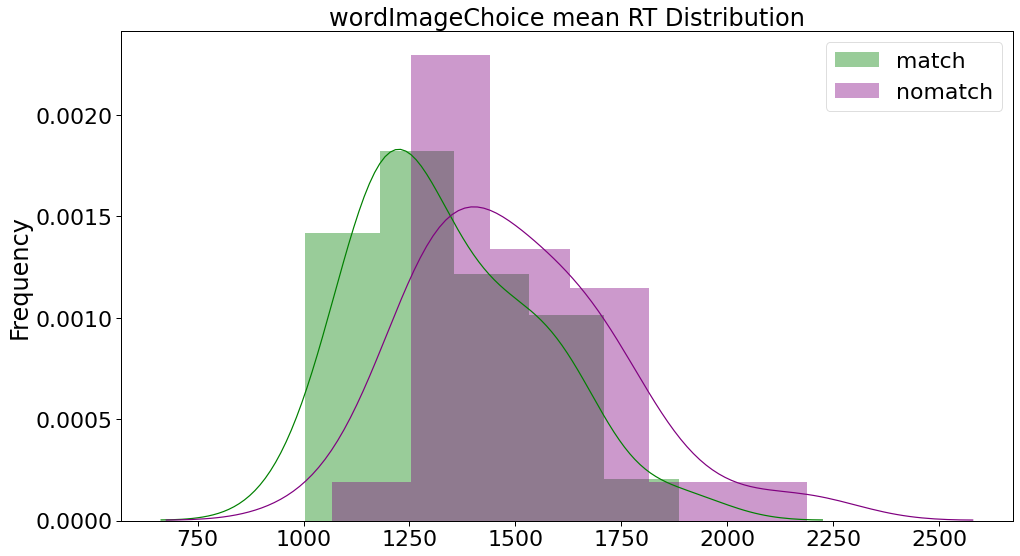

In [52]:
# match/nomatch
sns.distplot(wi_df_corr[wi_df_corr["relation"] == "match"].groupby("sub")["rt"].mean(), color="green", label="match")
sns.distplot(wi_df_corr[wi_df_corr["relation"] == "nomatch"].groupby("sub")["rt"].mean(), color="purple", label="nomatch")
plt.legend()
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("wordImageChoice mean RT Distribution")
# plt.savefig("./figures/wordchoice/rt-match.svg", bbox_inches="tight")

In [53]:
stats.ttest_rel(wi_df_corr[wi_df_corr["relation"] == "match"].groupby("sub")["rt"].mean(), wi_df_corr[wi_df_corr["relation"] == "nomatch"].groupby("sub")["rt"].mean())

Ttest_relResult(statistic=-9.320624772282995, pvalue=6.282573682472002e-10)

<ipython-input-54-2debd867e717>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(wi_df_corr[(wi_df_corr["animacy"] == "animate") & (wi_df.relation == "match")]["rt"], color="green", label="animate")
<ipython-input-54-2debd867e717>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(wi_df_corr[(wi_df_corr["animacy"] == "inanimate") & (wi_df.relation == "match")]["rt"], color="purple", label="inanimate")


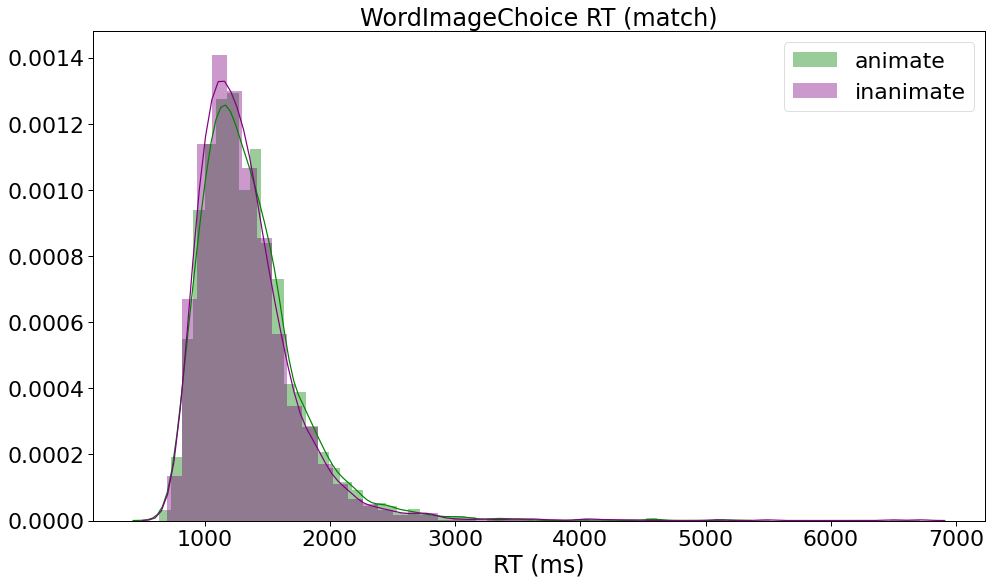

In [54]:
# animate/non-animate
sns.distplot(wi_df_corr[(wi_df_corr["animacy"] == "animate") & (wi_df.relation == "match")]["rt"], color="green", label="animate")
sns.distplot(wi_df_corr[(wi_df_corr["animacy"] == "inanimate") & (wi_df.relation == "match")]["rt"], color="purple", label="inanimate")
plt.legend()
plt.xlabel("RT (ms)")
plt.title("WordImageChoice RT (match)")
plt.savefig("../figures/wimatch/rt-animacy.svg", bbox_inches="tight")

### wordImageChoice acc

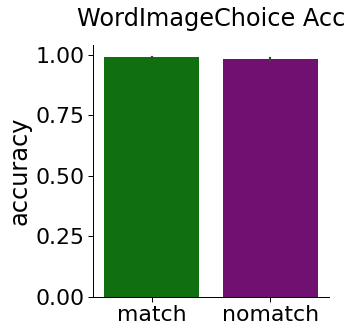

In [55]:
# accuracy
sns.catplot(x="relation", y="correct", kind="bar", palette=sns.color_palette(["green", "purple"]), data=wi_df)
plt.xlabel("")
plt.ylabel("accuracy")
plt.title("WordImageChoice Acc", y=1.05)
plt.savefig("../figures/wimatch/acc-match.svg", bbox_inches="tight")

## word vs. image

In [56]:
merge_columns = ["stimuli", "item", "relation", "animacy", "correct", "rt"]
merge_df = pd.concat([word_df[merge_columns], image_df[merge_columns]], ignore_index=True)

In [57]:
merge_df_corr = merge_df[merge_df["correct"] == True]

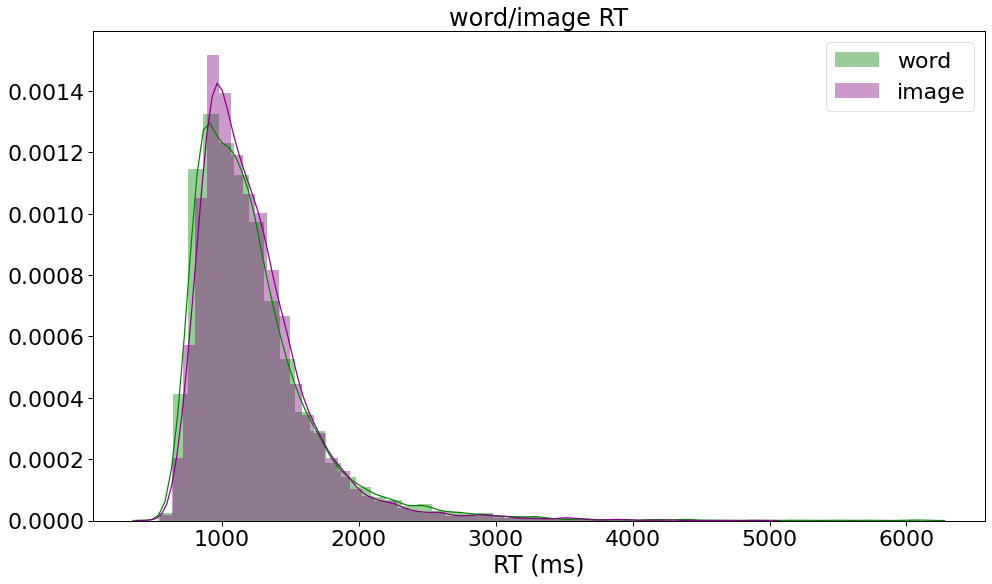

In [58]:
# word/image RT
sns.distplot(merge_df_corr[merge_df_corr["stimuli"] == "word"]["rt"], color="green", label="word")
sns.distplot(merge_df_corr[merge_df_corr["stimuli"] == "image"]["rt"], color="purple", label="image")
plt.legend()
plt.xlabel("RT (ms)")
plt.title("word/image RT")
plt.savefig("../figures/rt-stimuli.svg", bbox_inches="tight")

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


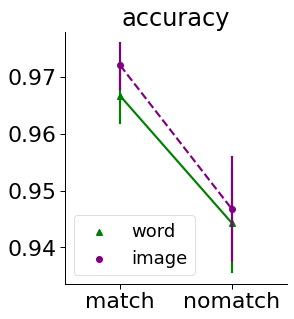

In [59]:
# accuracy
# sns.catplot(x="relation", y="correct", hue="stimuli", kind="bar", data=merge_df)
sns.catplot(x="relation", y="correct", hue="stimuli", kind="point", palette={"word": "green", "image": "purple"}, markers=["^", "o"], linestyles=["-", "--"], legend=False, data=merge_df)
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="lower left", fontsize=18)
plt.title("accuracy")
plt.savefig("../figures/acc-match.svg", bbox_inches="tight")

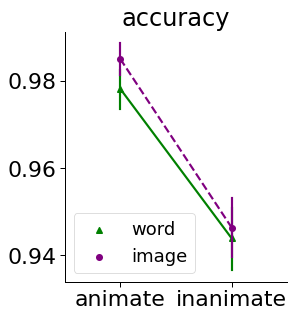

In [60]:
# accuracy
sns.catplot(x="animacy", y="correct", hue="stimuli", kind="point", palette={"word": "green", "image": "purple"}, markers=["^", "o"], linestyles=["-", "--"], legend=False, data=merge_df)
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="lower left", fontsize=18)
plt.title("accuracy")
plt.savefig("../figures/acc-animacy.svg", bbox_inches="tight")

## save data

In [61]:
common_col = ["option_left", "option_right", "trialN", "xTrajectory", "yTrajectory", "tTrajectory", "side", "sub", "rt", "animacy", "relation", "response", "correct"]
word_image_col = ["item"] + common_col + ["stimuli"]
wi_col = ["item_word", "item_image"] + common_col

In [62]:
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
word_df[word_df.correct == True][word_image_col].to_csv(os.path.join(new_data_path, wordtask + ".csv"), index=False)
image_df[image_df.correct == True][word_image_col].to_csv(os.path.join(new_data_path, imagetask + ".csv"), index=False)
wi_df[wi_df.correct == True][wi_col].to_csv(os.path.join(new_data_path, witask + ".csv"), index=False)
food_df.to_csv(os.path.join(new_data_path, foodtask + ".csv"), index=False)